Source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

### Load data

In [30]:
PATH = '~/pytorch_data/'
BS = 4
LR = 0.001
MOMENTUM = 0.9
EPOCHS = 2

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),  # Convert PIL image to tensor
     # Convert each channel using (input - mean) / std
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_ds = torchvision.datasets.CIFAR10(root=PATH, train=True, download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=2)

test_ds = torchvision.datasets.CIFAR10(root=PATH, train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BS, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_ds

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /Users/anton/pytorch_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [12]:
test_ds

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: /Users/anton/pytorch_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [13]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

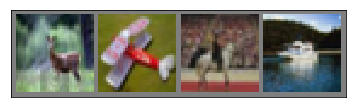

    deer    plane    horse     ship


In [22]:
def show_image(image):
    image = image / 2 + 0.5  # unnormalize
    image = np.transpose(image.numpy(), (1, 2, 0))  # permute dimensions, so that color is last dimension
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

images, labels = iter(train_dl).next()
show_image(torchvision.utils.make_grid(images))

print(' '.join('%8s' % classes[labels[j]] for j in range(BS)))

### Train NN

In [35]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  # 3x32x32 -> 6x28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 6x28x28 -> 6x14x14, takes max
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6x14x14 -> 16x10x10
        # We repeat pool and get 16x10x10 -> 16x5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM)

In [37]:
def fit():
    for epoch in range(EPOCHS):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_dl):
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

In [38]:
%%time
fit()

[1,  2000] loss: 2.231
[1,  4000] loss: 1.907
[1,  6000] loss: 1.721
[1,  8000] loss: 1.608
[1, 10000] loss: 1.515
[1, 12000] loss: 1.463
[2,  2000] loss: 1.400
[2,  4000] loss: 1.348
[2,  6000] loss: 1.313
[2,  8000] loss: 1.303
[2, 10000] loss: 1.278
[2, 12000] loss: 1.257
CPU times: user 13min 47s, sys: 1min 5s, total: 14min 52s
Wall time: 2min 19s


### Test NN

In [44]:
def show_predictions():
    images, labels = iter(train_dl).next()
    show_image(torchvision.utils.make_grid(images))

    print('Ground Truth:', ' '.join('%5s' % classes[labels[j]] for j in range(BS)))

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]] for j in range(BS)))

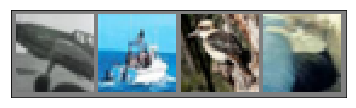

Ground Truth: plane  ship  bird   cat
Predicted:     bird  ship   dog  ship


In [45]:
show_predictions()

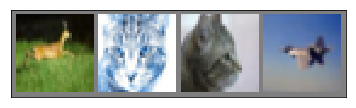

Ground Truth:  deer   cat   cat plane
Predicted:     deer  ship   cat  bird


In [43]:
show_predictions()

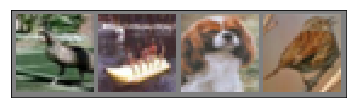

Ground Truth:  bird  ship   dog  bird
Predicted:    truck   cat   dog  bird


In [46]:
show_predictions()

In [47]:
correct = 0
total = 0
class_correct = [0] * len(classes)
class_total = [0] * len(classes)

net.eval()

with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_correct = (predicted == labels).squeeze()
        for i in range(BS):
            label = labels[i]
            class_correct[label] += predicted_correct[i].item()
            class_total[label] += 1

print('Accuracy: %d%%' % (100 * correct / total))

for i in range(len(classes)):
    print('Accuracy of %5s : %2d%%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy: 55%
Accuracy of plane : 62%
Accuracy of   car : 56%
Accuracy of  bird : 54%
Accuracy of   cat : 39%
Accuracy of  deer : 37%
Accuracy of   dog : 50%
Accuracy of  frog : 56%
Accuracy of horse : 71%
Accuracy of  ship : 59%
Accuracy of truck : 66%


### To train on GPU...

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [51]:
net.to(device);
# Modify fit() to include:
# inputs, labels = inputs.to(device), labels.to(device)